In [63]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import glob
import warnings

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import graphviz

file_dir = '/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

# drop first N hours of data in each wrfstat file
spin_up = 3

In [78]:
out_df = pd.DataFrame()

for wfile in glob.glob(file_dir+'wrfstat1*')[:2]: 
    
    wrfstat = xr.open_dataset(wfile)

    wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

    time_thres = wrfstat['XTIME'].min().values + np.timedelta64(spin_up, 'h')

    wrfstat = wrfstat.where(wrfstat['XTIME'] >= time_thres, drop=True)
    
    df1 = wrfstat['CSP_U'][:, 0:2].to_dataframe()
    df2 = wrfstat['CSP_V'][:, 0:2].to_dataframe()
    df3 = wrfstat['CSP_P'][:, 0:2].to_dataframe()
    df4 = wrfstat['CSP_WS'][:, 2].to_dataframe()

    combine_df = reduce(lambda left, right: pd.merge(left, right, 
                                                     left_index=True, right_index=True), [df1, df2, df3])

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        data_df = pd.merge(combine_df.unstack(), df4, left_index=True, right_index=True)
    
    out_df = out_df.append(data_df)

In [79]:
out_df

,"(CSP_U, 0)","(CSP_U, 1)","(CSP_V, 0)","(CSP_V, 1)","(CSP_P, 0)","(CSP_P, 1)",CSP_WS
Time,,,,,,,
0,1.658794,1.899871,6.138514,7.014305,97629.554688,97287.609375,7.634670
1,1.678893,1.919480,6.028211,6.884695,97629.921875,97287.984375,7.513640
2,1.698010,1.936806,5.946560,6.791562,97630.296875,97288.359375,7.425989
3,1.679016,1.909974,5.890436,6.717105,97630.703125,97288.765625,7.333262
4,1.665565,1.903430,5.819814,6.633324,97631.078125,97289.171875,7.249346
...,...,...,...,...,...,...,...
68,0.372972,1.007963,0.197293,0.531278,97056.859375,96713.835938,1.353936
69,0.341031,0.996221,0.181423,0.529201,97056.867188,96713.835938,1.356031
70,0.311513,0.983833,0.166659,0.525424,97056.898438,96713.835938,1.357212


In [ ]:
X = out_df.drop(['CSP_WS'], axis=1)
y = out_df['CSP_WS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

## XGBoost

In [74]:
regressor = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=4,
    subsample=0.8,
)

regressor.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)
    y_pred = regressor.predict(X_test)
    
print(mean_squared_error(y_test, y_pred))

0.017534044


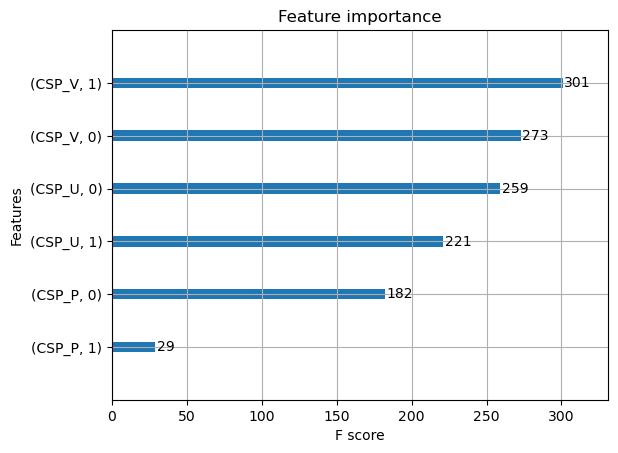

In [75]:
xgb.plot_importance(regressor)
plt.show()

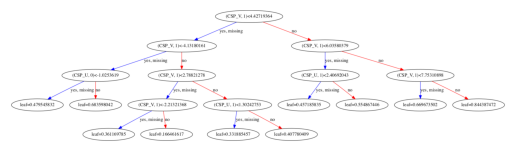

In [76]:
# need to install graphviz on conda (Python) and brew (system)
xgb.plot_tree(regressor, num_trees=1)
plt.show()

In [59]:
regressor = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [2, 5, 10],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.6, 0.7, 0.8]
}

# Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
# Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 
#                        'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 
#                        'reg_lambda': 1.3, 'subsample': 0.8}

grid_search = GridSearchCV(regressor, param_grid, 
                           scoring='neg_mean_squared_error', n_jobs=-1, cv=10, verbose=2)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
Best: -0.013091 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 1.2, 'reg_lambda': 1.3, 'subsample': 0.8}
-4.467926 (0.469339) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.6}
-4.457242 (0.472684) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.7}
-4.448175 (0.461980) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8}
-4.473180 (0.470229) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 1.1, 'reg_lambda': 1.2, 'subsample': 0.6}
-4.462707 (0.473925) with: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 2, 'n_esti

## Random forest

In [68]:
regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
)

regressor.fit(X_train, y_train)

# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=UserWarning)
y_pred = regressor.predict(X_test)
    
print(mean_squared_error(y_test, y_pred))

0.45153919627150607


In [73]:
regressor = RandomForestRegressor()

param_dist = {'max_depth': [3, None],
              'max_features': sp_randint(1, X_train.shape[1]),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap': [True, False],
              'n_estimators': sp_randint(100, 500)}

random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, 
                                   n_iter=10, cv=10, random_state=42)
random_search.fit(X_train, y_train)
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Best: -0.010095 using {'bootstrap': False, 'max_depth': None, 'max_features': 2, 'min_samples_split': 6, 'n_estimators': 260}


## Examine wrfstat files

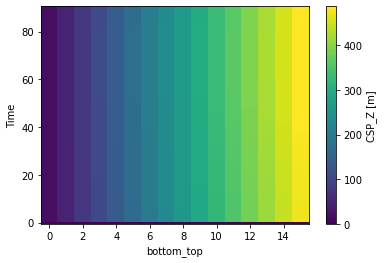

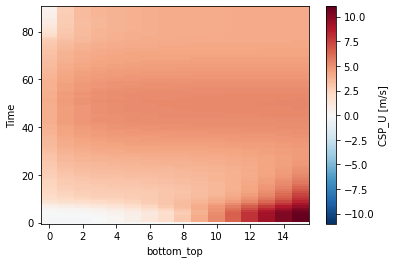

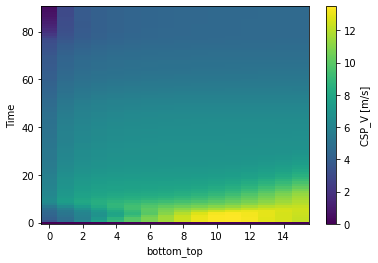

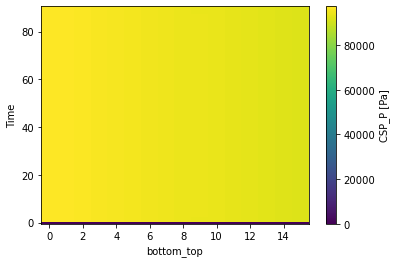

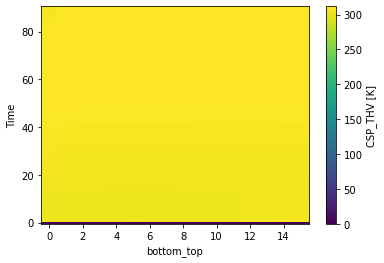

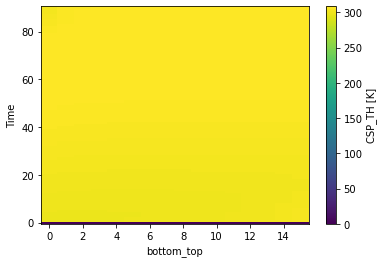

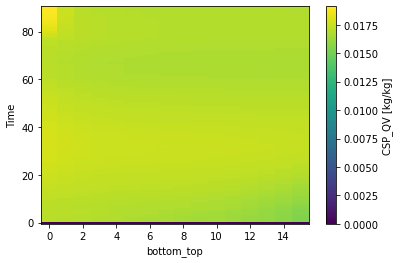

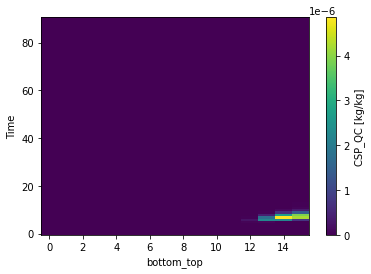

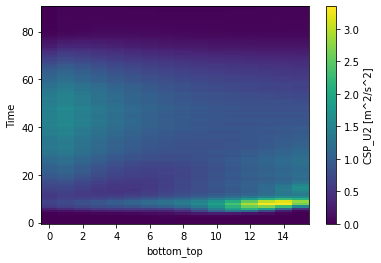

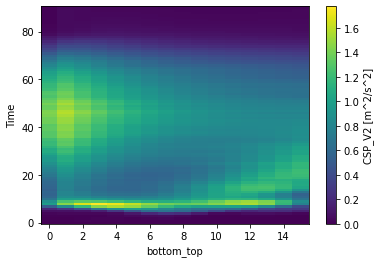

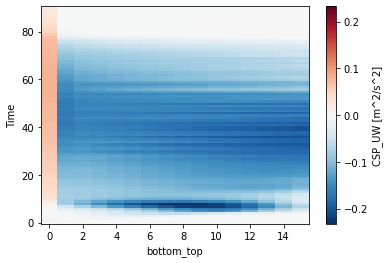

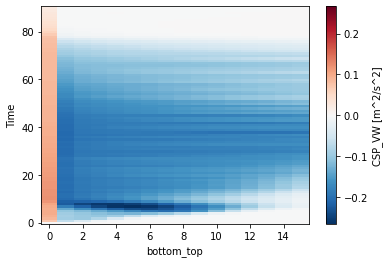

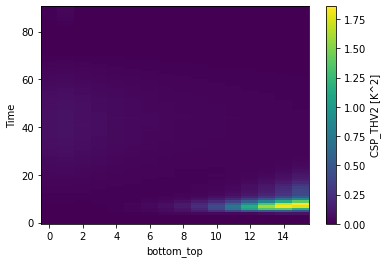

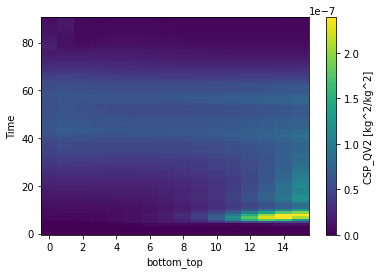

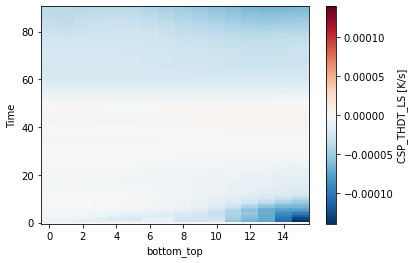

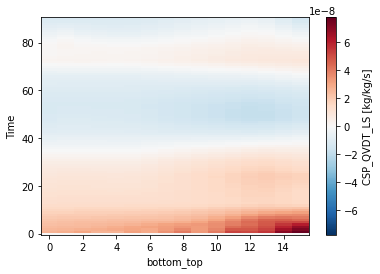

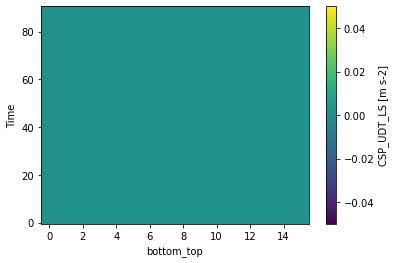

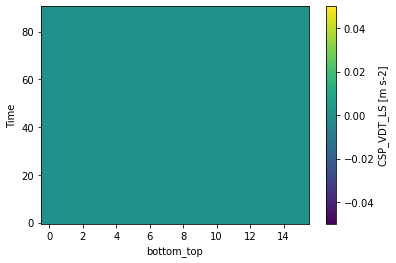

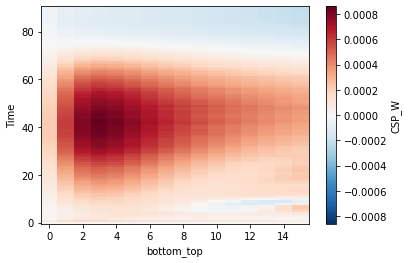

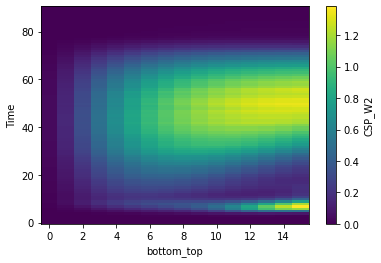

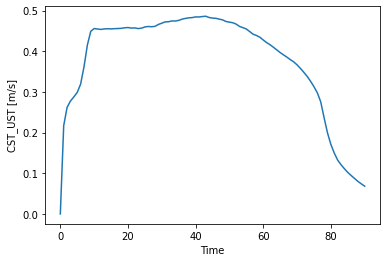

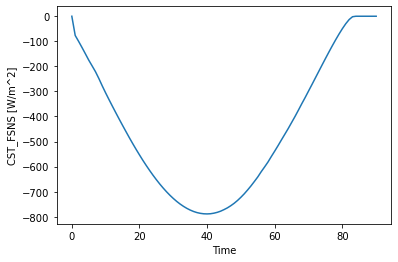

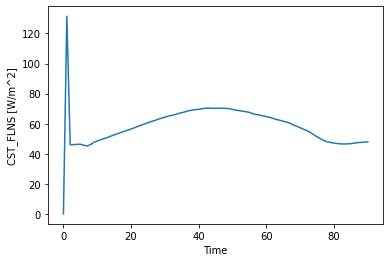

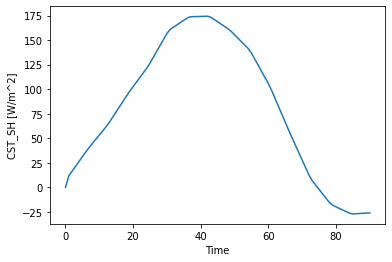

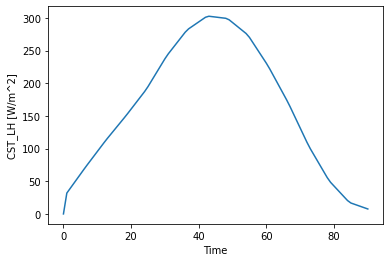

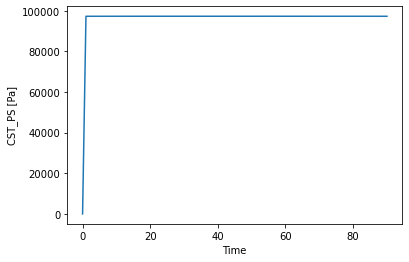

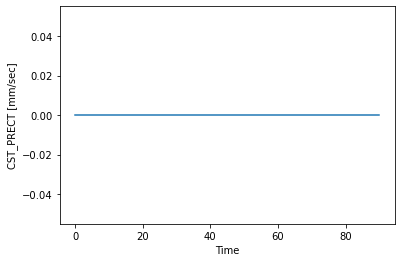

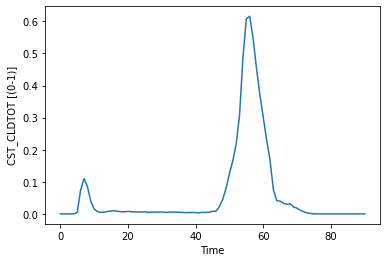

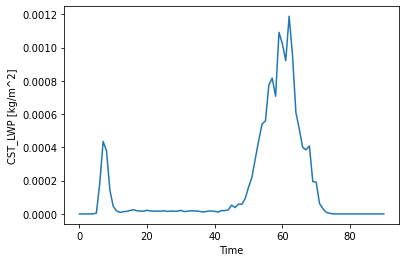

In [27]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2019-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

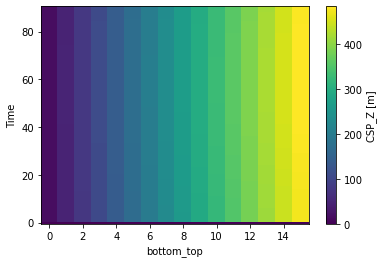

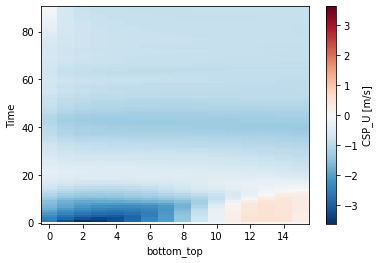

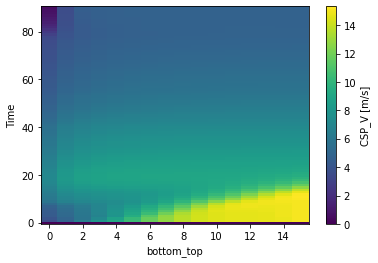

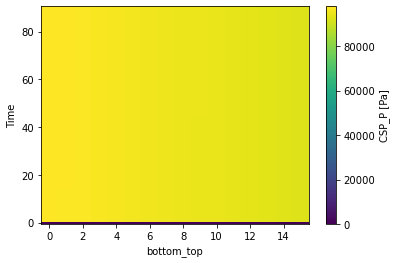

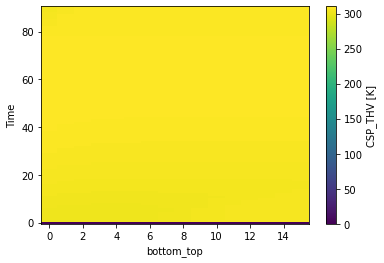

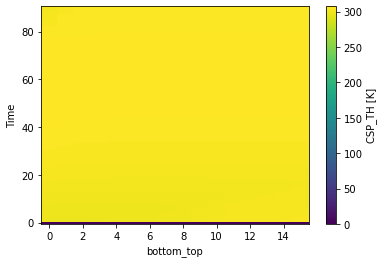

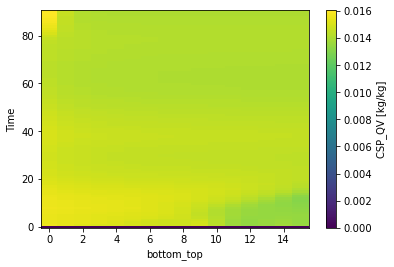

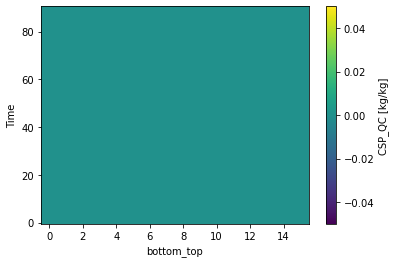

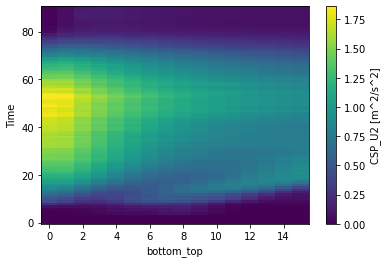

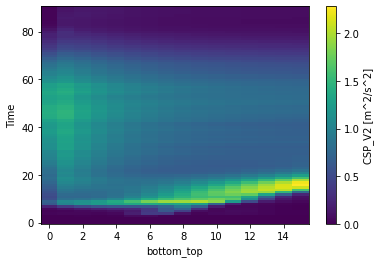

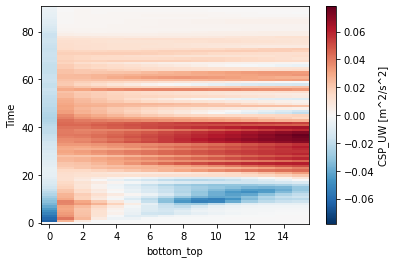

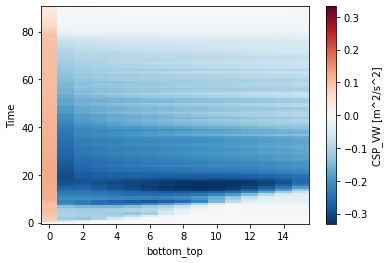

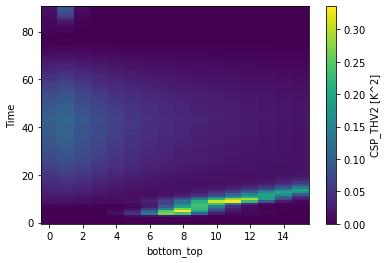

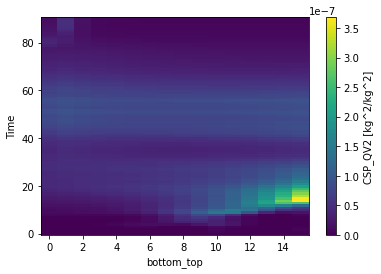

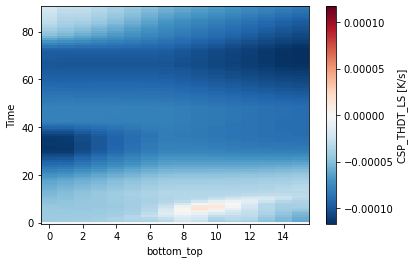

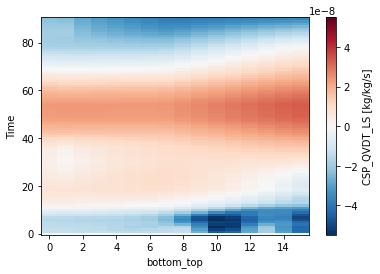

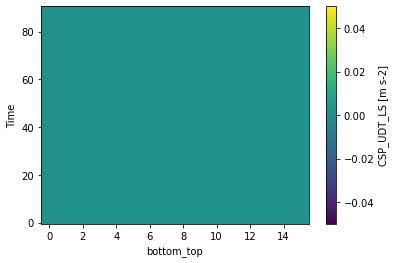

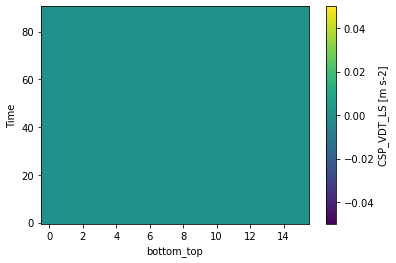

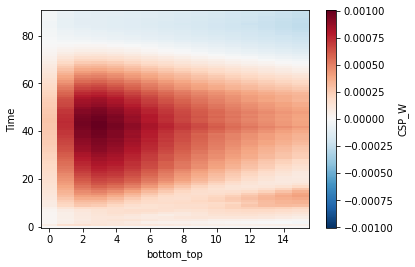

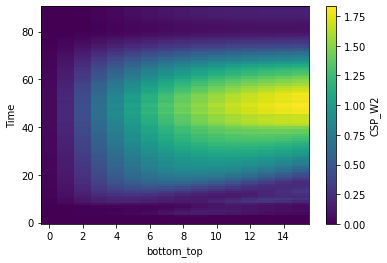

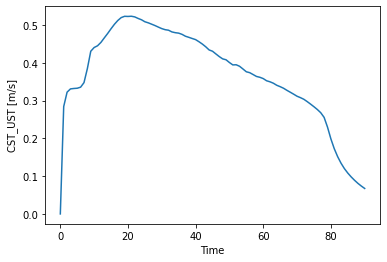

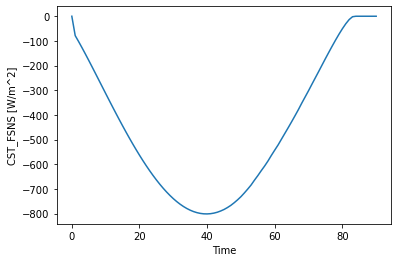

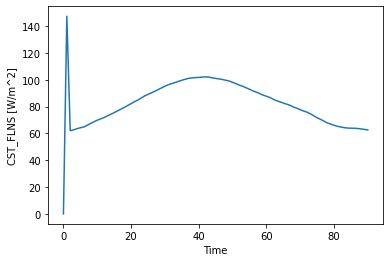

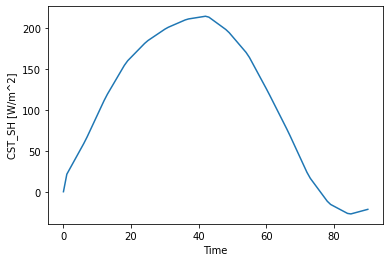

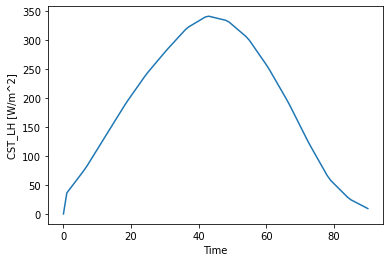

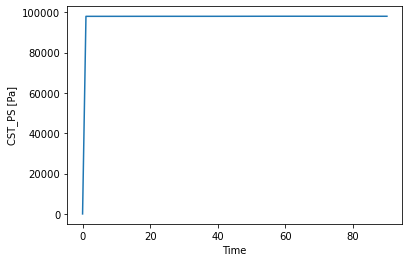

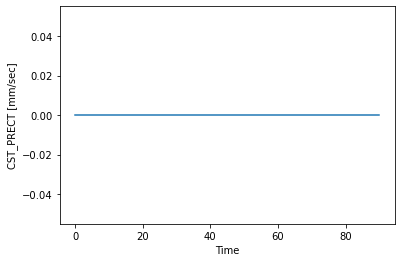

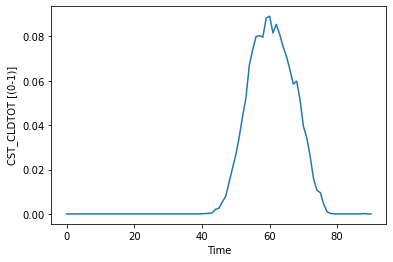

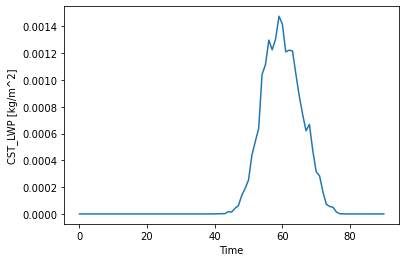

In [28]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat2_d01_2018-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

In [62]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2019-07-04_12:00:00.nc')

In [63]:
test['XLAT'].values.squeeze().shape

(91, 250, 250)

1545772

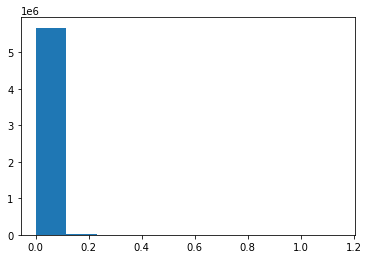

In [64]:
plt.hist(test['XLAT'].values.flatten())
(test['XLAT'].values.flatten() != 0).sum()

(array([5.681566e+06, 4.301000e+03, 9.670000e+02, 3.310000e+02,
        1.850000e+02, 6.600000e+01, 4.400000e+01, 2.400000e+01,
        1.100000e+01, 5.000000e+00]),
 array([0.        , 0.00236877, 0.00473753, 0.0071063 , 0.00947507,
        0.01184384, 0.0142126 , 0.01658137, 0.01895014, 0.0213189 ,
        0.02368767], dtype=float32),
 <BarContainer object of 10 artists>)

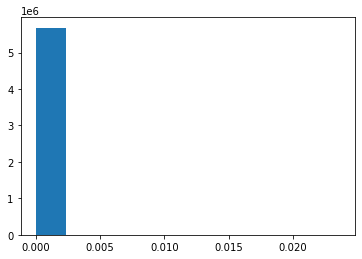

In [57]:
test = xr.open_dataset('/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'
                       +'wrfstat1_d01_2018-07-04_12:00:00.nc')
plt.hist(test['XLAT'].values.flatten())

In [61]:
(test['XLAT'].values.flatten() != 0).sum()

94547

In [65]:
test

<xarray.Dataset>
Dimensions:      (Time: 91, bottom_top: 16, south_north: 250, west_east: 250)
Coordinates:
    XLAT         (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    XLONG        (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    CSP_Z        (Time, bottom_top) float32 ...
    CSP_U        (Time, bottom_top) float32 ...
    CSP_V        (Time, bottom_top) float32 ...
    CSP_P        (Time, bottom_top) float32 ...
    CSP_THV      (Time, bottom_top) float32 ...
    CSP_TH       (Time, bottom_top) float32 ...
    CSP_QV       (Time, bottom_top) float32 ...
    CSP_QC       (Time, bottom_top) float32 ...
    CSP_U2       (Time, bottom_top) float32 ...
    CSP_V2       (Time, bottom_top) float32 ...
    CSP_UW       (Time, bottom_top) float32 ...
    CSP_VW       (Time, bottom_top) float32 ...
    CSP_THV2     (Time, bottom_top) float32 ...
    CSP_QV2      (Time, bottom_top) float32 ...
    CSP_THDT_LS  (Time, bottom_top) float32 ...
    CSP_QVDT_LS  (Time, bottom_top) float32 ...
    CSP_UDT_LS   (Time, bottom_top) float32 ...
    CSP_VDT_LS   (Time, bottom_top) float32 ...
    CSP_W        (Time, bottom_top) float32 ...
    CSP_W2       (Time, bottom_top) float32 ...
    CST_UST      (Time) float32 ...
    CST_FSNS     (Time) float32 ...
    CST_FLNS     (Time) float32 ...
    CST_SH       (Time) float32 ...
    CST_LH       (Time) float32 ...
    CST_PS       (Time) float32 ...
    CST_PRECT    (Time) float32 ...
    CST_CLDTOT   (Time) float32 ...
    CST_LWP      (Time) float32 ...
    Times        (Time) |S19 ...
Attributes:
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-07-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    DY:                                    100.0
    GRIDTYPE:                              C
    DIFF_OPT:                              2
    KM_OPT:                                2
    DAMP_OPT:                              3
    DAMPCOEF:                              0.2
    KHDIF:                                 1.0
    KVDIF:                                 1.0
    MP_PHYSICS:                            8
    RA_LW_PHYSICS:                         4
    RA_SW_PHYSICS:                         4
    SF_SFCLAY_PHYSICS:                     1
    SF_SURFACE_PHYSICS:                    1
    BL_PBL_PHYSICS:                        0
    CU_PHYSICS:                            0
    SF_LAKE_PHYSICS:                       0
    SURFACE_INPUT_SOURCE:                  3
    SST_UPDATE:                            0
    GRID_FDDA:                             0
    GFDDA_INTERVAL_M:                      0
    GFDDA_END_H:                           0
    GRID_SFDDA:                            0
    SGFDDA_INTERVAL_M:                     0
    SGFDDA_END_H:                          0
    HYPSOMETRIC_OPT:                       1
    USE_THETA_M:                           1
    WEST-EAST_PATCH_START_UNSTAG:          1
    WEST-EAST_PATCH_END_UNSTAG:            250
    WEST-EAST_PATCH_START_STAG:            1
    WEST-EAST_PATCH_END_STAG:              251
    SOUTH-NORTH_PATCH_START_UNSTAG:        1
    SOUTH-NORTH_PATCH_END_UNSTAG:          250
    SOUTH-NORTH_PATCH_START_STAG:          1
    SOUTH-NORTH_PATCH_END_STAG:            251
    BOTTOM-TOP_PATCH_START_UNSTAG:         1
    BOTTOM-TOP_PATCH_END_UNSTAG:           226
    BOTTOM-TOP_PATCH_START_STAG:           1
    BOTTOM-TOP_PATCH_END_STAG:             227
    GRID_ID:                               1
    PARENT_ID:                             0
    I_PARENT_START:                        0
    J_PARENT_START:                        0
    PARENT_GRID_RATIO:                     1
    DT: 